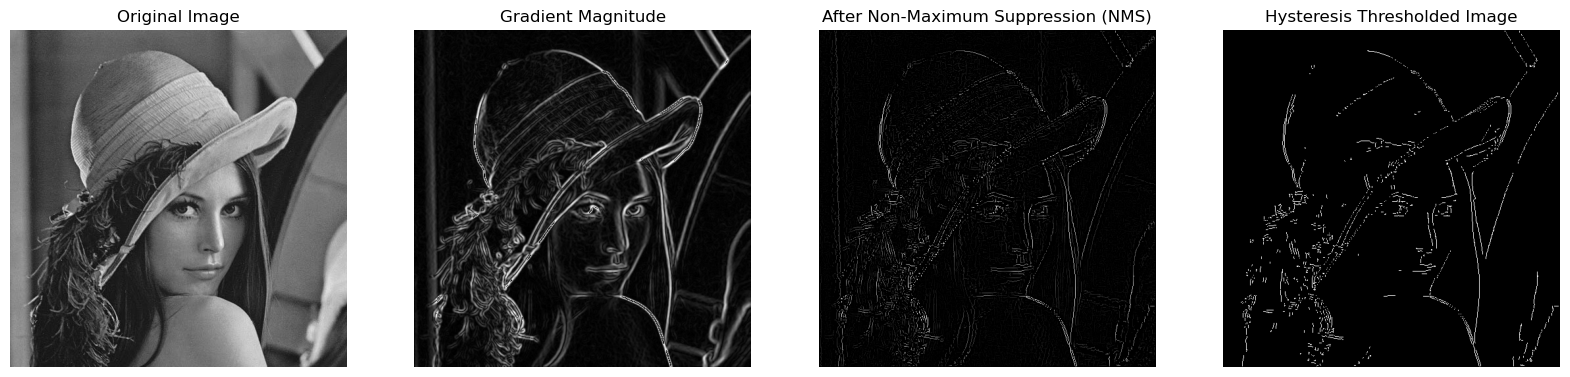

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
#roses_path = os.path.join(os.getcwd(), 'data', 'images', 'roses.jpg')
lena_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')

# Load the original images in grayscale
#roses_image = cv2.imread(roses_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)

# Apply GaussianBlur to reduce noise (important for clean edge detection)
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

# Compute the gradients in x and y directions using the Sobel operator
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x direction
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y direction

# Calculate the gradient magnitude and direction
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_magnitude = np.uint8(gradient_magnitude)
gradient_direction = np.arctan2(sobel_y, sobel_x)  # Gradient direction in radians

# Non-Maximum Suppression
nms_image = np.zeros_like(gradient_magnitude)
angle = gradient_direction * (180 / np.pi)  # Convert to degrees
angle[angle < 0] += 180  # Ensure all angles are positive

# Iterate over the image to apply NMS
for y in range(1, gradient_magnitude.shape[0] - 1):
    for x in range(1, gradient_magnitude.shape[1] - 1):
        q = 255
        r = 255

        # Angle 0 degrees
        if (0 <= angle[y, x] < 22.5) or (157.5 <= angle[y, x] <= 180):
            q = gradient_magnitude[y, x + 1]
            r = gradient_magnitude[y, x - 1]
        # Angle 45 degrees
        elif 22.5 <= angle[y, x] < 67.5:
            q = gradient_magnitude[y + 1, x - 1]
            r = gradient_magnitude[y - 1, x + 1]
        # Angle 90 degrees
        elif 67.5 <= angle[y, x] < 112.5:
            q = gradient_magnitude[y + 1, x]
            r = gradient_magnitude[y - 1, x]
        # Angle 135 degrees
        elif 112.5 <= angle[y, x] < 157.5:
            q = gradient_magnitude[y - 1, x - 1]
            r = gradient_magnitude[y + 1, x + 1]

        # Suppress non-maximum pixels
        if (gradient_magnitude[y, x] >= q) and (gradient_magnitude[y, x] >= r):
            nms_image[y, x] = gradient_magnitude[y, x]
        else:
            nms_image[y, x] = 0

# Set the high and low threshold values for hysteresis thresholding
high_threshold = 100  # High threshold for strong edges
low_threshold = 50    # Low threshold for potential weak edges

# Initialize an empty array to store the result of hysteresis thresholding
hysteresis_output = np.zeros_like(nms_image)

# Apply hysteresis thresholding
strong_edges = (nms_image >= high_threshold)
hysteresis_output[strong_edges] = 255  # Mark strong edges

weak_edges = ((nms_image >= low_threshold) & (nms_image < high_threshold))

# Check each weak edge pixel to see if it's connected to any strong edge pixels
for y in range(1, hysteresis_output.shape[0] - 1):
    for x in range(1, hysteresis_output.shape[1] - 1):
        if weak_edges[y, x]:
            # Check 8-connected neighborhood for strong edge pixels
            if np.any(strong_edges[y-1:y+2, x-1:x+2]):
                hysteresis_output[y, x] = 255  # Promote to strong edge

# Display the original, gradient magnitude, NMS result, and hysteresis thresholded images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Original Image
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

# Gradient Magnitude Image
ax[1].imshow(gradient_magnitude, cmap="gray")
ax[1].set_title("Gradient Magnitude")
ax[1].axis("off")

# Non-Maximum Suppressed Image
ax[2].imshow(nms_image, cmap="gray")
ax[2].set_title("After Non-Maximum Suppression (NMS)")
ax[2].axis("off")

# Hysteresis Thresholded Image
ax[3].imshow(hysteresis_output, cmap="gray")
ax[3].set_title("Hysteresis Thresholded Image")
ax[3].axis("off")

plt.show()
